In [1]:
import tensorflow as tf
import tensorflow.keras as tfk

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time

print(tf.__version__)

2.0.0-alpha0


## Download and prepare the dataset

In [2]:
path_to_zip = tf.keras.utils.get_file(
    'spa-eng.zip', origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip', 
    extract=True)
path_to_file = os.path.dirname(path_to_zip)+"/spa-eng/spa.txt"

2646016/2638744 [==============================] - 2s 1us/step


In [3]:
os.path.dirname(path_to_zip)

'/home/xiucheng/.keras/datasets'

In [4]:
# Converts the unicode file to ascii
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')


def preprocess_sentence(w):
    w = unicode_to_ascii(w.lower().strip())
    
    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ." 
    # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)
    
    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)
    
    w = w.rstrip().strip()
    
    # adding a start and an end token to the sentence
    # so that the model know when to start and stop predicting.
    w = '<start> ' + w + ' <end>'
    return w

In [5]:
en_sentence = u"May I borrow this book?"
sp_sentence = u"¿Puedo tomar prestado este libro?"
print(preprocess_sentence(en_sentence))
print(preprocess_sentence(sp_sentence).encode('utf-8'))

<start> may i borrow this book ? <end>
b'<start> \xc2\xbf puedo tomar prestado este libro ? <end>'


In [6]:
# 1. Remove the accents
# 2. Clean the sentences
# 3. Return word pairs in the format: [ENGLISH, SPANISH]
def create_dataset(path, num_examples):
    lines = io.open(path, encoding='UTF-8').read().strip().split('\n')
    
    word_pairs = [[preprocess_sentence(w) for w in l.split('\t')]  for l in lines[:num_examples]]
    
    return zip(*word_pairs)

In [7]:
en, sp = create_dataset(path_to_file, None)
print(en[-1])
print(sp[-1])

<start> if you want to sound like a native speaker , you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo . <end>
<start> si quieres sonar como un hablante nativo , debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la misma manera en que un musico de banjo practica el mismo fraseo una y otra vez hasta que lo puedan tocar correctamente y en el tiempo esperado . <end>


In [8]:
def max_length(tensor):
    return max(len(t) for t in tensor)

def tokenize(lang):
    lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
          filters='')
    lang_tokenizer.fit_on_texts(lang)
  
    tensor = lang_tokenizer.texts_to_sequences(lang)
  
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                         padding='post')

    return tensor, lang_tokenizer

In [9]:
def load_dataset(path, num_examples=None):
    # creating cleaned input, output pairs
    targ_lang, inp_lang = create_dataset(path, num_examples)

    input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
    target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

    return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

In [10]:
num_examples = 30000
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file, num_examples)

# Calculate max_length of the target tensors
max_length_targ, max_length_inp = max_length(target_tensor), max_length(input_tensor)

In [11]:
print(input_tensor.shape)
print(target_tensor.shape)

(30000, 16)
(30000, 11)


In [12]:
# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# Show length
len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val)

(24000, 24000, 6000, 6000)

In [13]:
def convert(lang, tensor):
    for t in tensor:
        if t!=0:
            print ("%d ----> %s" % (t, lang.index_word[t]))

In [14]:
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])

Input Language; index to word mapping
1 ----> <start>
4 ----> tom
16 ----> esta
36 ----> muy
469 ----> despierto
3 ----> .
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
5 ----> tom
8 ----> is
1399 ----> wide
475 ----> awake
3 ----> .
2 ----> <end>


In [15]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [16]:
example_input_batch, example_target_batch = next(iter(dataset))

In [17]:
example_input_batch.device

'/job:localhost/replica:0/task:0/device:CPU:0'

## Encoder, Decoder and Attention 

In [18]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_size):
        super(Encoder, self).__init__()
        self.batch_size = batch_size
        self.enc_units = enc_units
        self.embedding = tfk.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tfk.layers.GRU(self.enc_units,
                                  return_sequences=True,
                                  return_state=True,
                                  recurrent_initializer='glorot_uniform')

    def call(self, x, h0):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state=h0)
        return output, state
    
    def initialize_hidden_state(self):
        return tf.zeros([self.batch_size, self.enc_units])

In [109]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

In [110]:
h0 = encoder.initialize_hidden_state()
sample_output, hn = encoder(example_input_batch, h0)

print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(hn.shape))

Encoder output shape: (batch size, sequence length, units) (64, 16, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


In [26]:
tf.expand_dims?

![](https://www.tensorflow.org/images/seq2seq/attention_mechanism.jpg)

![](https://www.tensorflow.org/images/seq2seq/attention_equation_0.jpg)
![](https://www.tensorflow.org/images/seq2seq/attention_equation_1.jpg)

In [21]:
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tfk.layers.Dense(units)
        self.W2 = tfk.layers.Dense(units)
        self.V  = tfk.layers.Dense(1)
        
    def call(self, query, values):
        """
        query (batch size, hidden size): h_t
        values (batch size, max length, hidden size): h_s
        """
        ## (batch size, hidden size) => (batch size, 1, hidden size)
        query_with_time_axis = tf.expand_dims(query, 1)
        ## (batch size, max length, 1)
        score = self.V(tf.nn.tanh(
            self.W1(query_with_time_axis) + self.W2(values)))
        
        ## normalizing along the second dimension
        ## (batch size, max length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)
        
        ## (batch size, max length, hidden size) => (batch size, hidden size)
        context_vector = tf.reduce_sum(attention_weights * values, axis=1)
        
        return context_vector, attention_weights

In [111]:
attention_layer = BahdanauAttention(10)
context_vector, attention_weights = attention_layer(hn, sample_output)

print("Attention result shape: (batch size, units) {}".format(context_vector.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 16, 1)


In [23]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_size):
        super(Decoder, self).__init__()
        self.batch_size = batch_size
        self.dec_units = dec_units
        self.embedding = tfk.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tfk.layers.GRU(self.dec_units,
                                  return_sequences=True,
                                  return_state=True,
                                  recurrent_initializer='glorot_uniform')
        self.fc = tfk.layers.Dense(vocab_size)
        
        self.attention = BahdanauAttention(self.dec_units)
    
    def call(self, x, hidden, enc_output):
        """
        x (batch size, 1)
        hidden (batch size, hidden size)
        enc_output (batch size, max length, hidden size)
        """
        ## (batch size, hidden size), (batch size, hidden size, 1)
        context_vector, attention_weights = self.attention(hidden, enc_output)
        
        ## (batch size, 1, embedding size)
        x = self.embedding(x)
        
        ## (batch size, 1, hidden size + embedding size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        
        ## (batch size, 1, dec_units), (batch size, dec_units)
        output, state = self.gru(x)
        
        ## (batch size, dec_units)
        output = tf.reshape(output, [-1, output.shape[-1]])
        
        ## (batch size, vocab size)
        x = self.fc(output)
        
        return x, state, attention_weights

In [112]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform([64, 1]),
                                      hn, sample_output)

In [113]:
print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 4935)


## Optimizer and loss function

In [114]:
optimizer = tfk.optimizers.Adam()
loss_object = tfk.losses.SparseCategoricalCrossentropy(from_logits=True)

def loss_function(y, pred):
    mask = tf.math.logical_not(y == 0)
    loss = loss_object(y, pred)
    
    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask
    
    return tf.reduce_sum(loss)

In [115]:
checkpoint_dir = '/tmp/nmt/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [116]:
@tf.function
def train_step(inp, targ, enc_h0):
    loss = 0
    with tf.GradientTape() as tape:
        enc_output, enc_hn = encoder(inp, enc_h0)
        
        dec_h0 = enc_hn
        dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)
        
        ## iterating over time axis
        for i in range(1, targ.shape[1]):
            pred, dec_h0, _ = decoder(dec_input, dec_h0, enc_output)
            loss += loss_function(targ[:, i], pred)
            
            ## using teacher forcing
            dec_input = tf.expand_dims(targ[:, i], 1)
    
    trainable_variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(gradients, trainable_variables))
    
    return loss / targ.shape[1]

In [117]:
EPOCHS = 10

for epoch in range(EPOCHS):
    start = time.time()
    
    enc_h0 = encoder.initialize_hidden_state()
    total_loss = 0
    
    for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
        batch_loss = train_step(inp, targ, enc_h0)
        total_loss += batch_loss
        
        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch+1,
                                                         batch,
                                                         batch_loss.numpy()))
    
    if (epoch + 1) % 2 == 0:
        checkpoint.save(file_prefix=checkpoint_prefix)
        
    print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                        total_loss / steps_per_epoch))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 7.7319
Epoch 1 Batch 100 Loss 2.2308
Epoch 1 Batch 200 Loss 1.9724
Epoch 1 Batch 300 Loss 1.8364
Epoch 1 Loss 2.2228
Time taken for 1 epoch 42.734880685806274 sec

Epoch 2 Batch 0 Loss 1.6408
Epoch 2 Batch 100 Loss 1.5623
Epoch 2 Batch 200 Loss 1.4018
Epoch 2 Batch 300 Loss 1.3540
Epoch 2 Loss 1.4479
Time taken for 1 epoch 32.15692710876465 sec

Epoch 3 Batch 0 Loss 1.1170
Epoch 3 Batch 100 Loss 1.0756
Epoch 3 Batch 200 Loss 0.9715
Epoch 3 Batch 300 Loss 0.8981
Epoch 3 Loss 1.0099
Time taken for 1 epoch 31.493449687957764 sec

Epoch 4 Batch 0 Loss 0.7318
Epoch 4 Batch 100 Loss 0.7101
Epoch 4 Batch 200 Loss 0.6827
Epoch 4 Batch 300 Loss 0.6239
Epoch 4 Loss 0.6873
Time taken for 1 epoch 32.13424301147461 sec

Epoch 5 Batch 0 Loss 0.5168
Epoch 5 Batch 100 Loss 0.4736
Epoch 5 Batch 200 Loss 0.4614
Epoch 5 Batch 300 Loss 0.4025
Epoch 5 Loss 0.4685
Time taken for 1 epoch 31.446782112121582 sec

Epoch 6 Batch 0 Loss 0.3567
Epoch 6 Batch 100 Loss 0.3216
Epoch 6 Batch 200 L

## Evaluation

In [99]:
def evaluate(sentence):
    attention_plot = np.zeros([max_length_targ, max_length_inp])
    
    sentence = preprocess_sentence(sentence)
    
    inputs = [inp_lang.word_index[w] for w in sentence.split(' ')]
    inputs = tfk.preprocessing.sequence.pad_sequences([inputs],
                                                      maxlen=max_length_inp,
                                                      padding='post')
    inputs = tf.convert_to_tensor(inputs)
    
    result= ''
    
    enc_h0 = tf.zeros([1, units])
    enc_output, enc_hn = encoder(inputs, enc_h0)
    
    dec_h0 = enc_hn
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 1)
    
    ## iterating over the time axis
    for i in range(max_length_targ):
        pred, dec_h0, attention_weights = decoder(dec_input, dec_h0, enc_output)
        
        attention_weights = tf.reshape(attention_weights, [-1, ])
        attention_plot[i] = attention_weights.numpy()
        
        pred_id = tf.argmax(pred[0]).numpy()
        
        result += targ_lang.index_word[pred_id] + ' '
        
        if targ_lang.index_word[pred_id] == '<end>':
            return result, sentence, attention_plot
        
        ## preparing decoder input for next iteration
        dec_input = tf.expand_dims([pred_id], 0)
    
    return result, sentence, attention_plot

In [72]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')
    
    fontdict = {'fontsize': 14}
    
    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    plt.show()

In [73]:
def translate(sentence):
    result, sentence, attention_plot = evaluate(sentence)
        
    print('Input: %s' % (sentence).encode('utf-8'))
    print('Predicted translation: {}'.format(result))
    
    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [105]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input: b'<start> hace mucho frio aqui . <end>'
Predicted translation: it s very cold here . <end> 


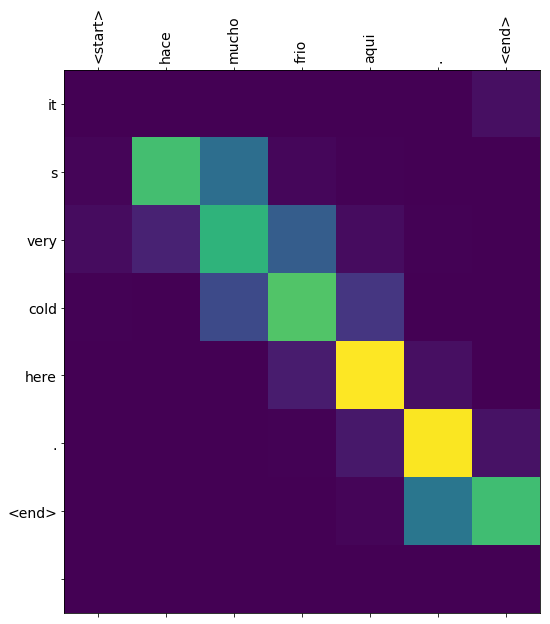

In [118]:
translate(u'hace mucho frio aqui.')

Input: b'<start> esta es mi vida . <end>'
Predicted translation: this is my life . <end> 


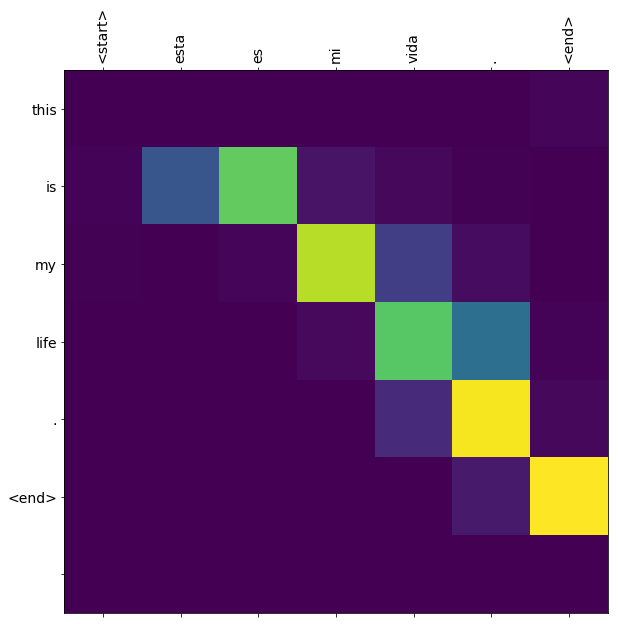

In [119]:
translate(u'esta es mi vida.')

Input: b'<start> \xc2\xbf todavia estan en casa ? <end>'
Predicted translation: are you still at home ? <end> 


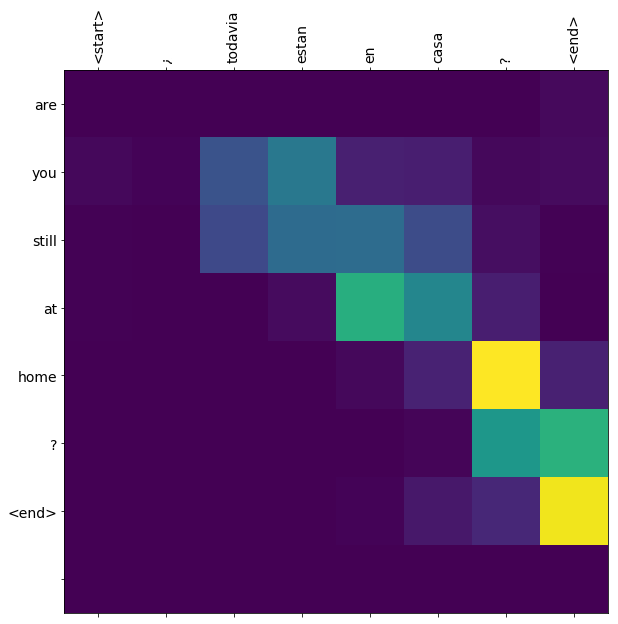

In [120]:
translate(u'¿todavia estan en casa?')